In [1]:
"""
A 1000 run of the gillespied function, with constant inputs 
"""

"A 1000 run of the gillespied function, with constant inputs \n"

In [2]:
using Distributed, Plots, DelimitedFiles, KernelDensity

In [3]:
length(Sys.cpu_info())
addprocs(4) ;

In [4]:
@everywhere using Random, Distributions

In [5]:
@everywhere struct SPN
    init::Vector{Real}
    rates::Vector{Real}
    Stoichiometry_matrix::Array{Real}
    function SPN(init, rates, Stoichiometry_matrix)
        new(init, rates, Stoichiometry_matrix)
    end
end

In [6]:
@everywhere init(N::SPN) = Float64.(N.init)
@everywhere rates(N::SPN) = Float64.(N.rates)
@everywhere StoiMat(N::SPN) = Float64.(N.Stoichiometry_matrix)

In [7]:
@everywhere function hazard(x::Vector{Float64}, th::Vector{Float64}, error::Float64)::Vector{Float64}
    k = th[1:5]
    Kc = th[6:7]
    if error>=0
        # defining the k1, & k2 and then subbing them into a vecotr is WAY WAY quicker
        # compared to calcing them in the vector
        k1 = k[1]+error*Kc[1]
        k2 = k[2]+error*Kc[1]
        return [x[1], x[2], x[1], x[2], x[1]].*[k1, k2, k[3], k[4], k[5]]
    else 
        k1 = 2*k[1]/(1+exp(-error*Kc[2]))
        k2 = 2*k[2]/(1+exp(-error*Kc[2]))
        return [x[1], x[2], x[1], x[2], x[1]].*[k1, k2, k[3], k[4], k[5]]
    end
end

In [8]:
@everywhere function hazzy(x::Vector{Float64}, th::Vector{Float64})::Vector{Float64}
    return [x[1], x[2], x[1], x[2], x[1]].*th[1:5]
end

In [9]:
@everywhere const post = [[2,0,0,0,1] [0,2,0,0,1]]
@everywhere const pre = [[1,0,1,0,1] [0,1,0,1,0]]
@everywhere const S = post - pre
@everywhere const k = [3.06e-8, 3.06e-8, 3.06e-8, 3.06e-8, 0.0, 8.99e-9, 2e-3];

In [10]:
@everywhere function gen_inits(μ::Real, σ::Real, α::Real, β::Real)::Vector{Float64}
    CC = rand(Normal(μ, σ))
    hh = rand(Beta(α, β))
    return round.( [CC*(1-hh), CC*hh] )
end

In [11]:
@everywhere function trans_summ(popdym)
    copy_num = popdym[:,1] .+ popdym[:,2]
    
    mut_load = Array{Union{Float64, Missing}}(undef, length(copy_num))
    idx = copy_num .!= 0.0
    mut_load[.!idx] .= missing
    mut_load[idx] .=  popdym[idx,2] ./ copy_num[idx]
    
    return hcat(copy_num, mut_load)
end

In [12]:
@everywhere function gillespied(N::SPN, Tmax::Real, dtout::Real)::Array{Union{Float64, Missing}}
    k = rates(N)
    x = init(N)
    Nout = trunc(Int, Tmax/dtout)
    S = StoiMat(N)
    xmat = Array{Union{Float64, Missing}}(undef, (2,Nout+1))
    xmat[:,1] = x
    i = 1
    tt = 0.0
    target = 0.0
    C0 = sum(x)
    while i <= Nout
        error = C0 - sum(x)
        h = hazzy(x, k)
        h0 = sum(h)
        if h0<1e-10
            xmat[:,i:(Nout+1)] = zeros(2,Nout-i+2)
            return trans_summ(xmat')
        else
            Exp = Exponential(1/h0)
            tt = tt + rand(Exp)
        end
        while tt>=target && i<=Nout
            i += 1
            xmat[:,i] = x
            target += dtout
        end
        Cat = Categorical(h/h0)
        r = rand(Cat)
        x += S'[:,r]
    end
    return trans_summ(xmat')
end

In [13]:
@everywhere function quantiles(sims, p)
    """
    returns quantile summaries from simulations
    """
    Nsim = size(sims)[3] # Nsim: number of simulations
    n = size(sims)[1] # length of one simulation
    out = Array{Float64}(undef, n,length(p),2)
    for t=1:n
        out[t,:,1] = quantile(skipmissing([sims[t,1,i] for i=1:Nsim]), p)
        out[t,:,2] = quantile(skipmissing([sims[t,2,i] for i=1:Nsim]), p)
    end
    out
end

In [14]:
Nsim = 1000
Tmax = 80*365*24*3600
step_out = 7*24*3600 ; 

In [15]:
Ntest = SPN([100,100], k, S)
@time gillespied(Ntest, Tmax, step_out);
"""
a single run takes ~0.03 seconds
"""

  1.210985 seconds (4.55 M allocations: 279.033 MiB, 4.49% gc time, 97.44% compilation time)


"a single run takes ~0.03 seconds\n"

In [16]:
"""
simulations_single = Array{Float64}(undef, n(Ntest), 2, Nsim)
@time for i=1:Nsim
    simulations_single[:,:,i] = gillespied(Ntest)
end
This is a lot slower (doubly slow) than the previous version without the SPN structure
For 1000 simulations 26.536 seconds
"""

"simulations_single = Array{Float64}(undef, n(Ntest), 2, Nsim)\n@time for i=1:Nsim\n    simulations_single[:,:,i] = gillespied(Ntest)\nend\nThis is a lot slower (doubly slow) than the previous version without the SPN structure\nFor 1000 simulations 26.536 seconds\n"

In [17]:
#summ_single = raw_to_summ(simulations_single);
#qnts_single = quantiles(summ_single, [0.025,0.1,0.5,0.9,0.975]) ;

In [18]:
# The arguments are: 1) a function 'f' and 2) a list with the input.
@everywhere function par_map(Nsim, f, SPN, Tmax, dtout)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/dtout) + 1 # dimension for output
    output = Array{Union{Float64, Missing}}(undef, Nout,2,Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[:,:,idx] = remotecall_fetch(f, p, SPN, Tmax, dtout)
                    end
                end
            end
        end
    end
    output
end

In [19]:
@time simulations = par_map(Nsim, gillespied, Ntest, Tmax, step_out) ;
"""
simple simulation: ~ 7.5 seconds
4 workers, 1000 simulations
"""

  9.239774 seconds (25.27 M allocations: 624.781 MiB, 2.98% gc time, 2.55% compilation time)


"simple simulation: ~ 7.5 seconds\n4 workers, 1000 simulations\n"

In [20]:
sims_qntl = quantiles(simulations, [0.025,0.25,0.5,0.75,0.975]) ;

In [21]:
mkpath("Simulations")

"Simulations"

In [22]:
writedlm("Simulations/CN_qnt_gill_jl.txt", sims_qntl[:,:,1])
writedlm("Simulations/ML_qnt_gill_jl.txt", sims_qntl[:,:,2])

In [23]:
function distributions_t(sims, t, Tsim, δt)
    t_tot = [δt:δt:Tsim;]
    Nsim = size(sims)[3]
    nt = length(t)
    sim_t = Array{Float64}(undef, Nsim,nt,2)
    for i=1:Nsim
        for j=1:nt
            sim_t[i,j,1] = sims[findall(x->x==t[j], t_tot),1,i][1]
            sim_t[i,j,2] = sims[findall(x->x==t[j], t_tot),2,i][1]
        end
    end
    sim_t
end


distributions_t (generic function with 1 method)

In [24]:
dist_sims = distributions_t(simulations, [10:10:80;]*365*24*3600, Tmax, step_out) ; 

LoadError: BoundsError: attempt to access 0-element Vector{Union{Missing, Float64}} at index [1]

In [25]:
writedlm("Simulations/CN_ts_gill_jl.txt", dist_sims[:,:,1])
writedlm("Simulations/ML_ts_gill_jl.txt", dist_sims[:,:,2])

LoadError: UndefVarError: dist_sims not defined

In [26]:
"""
Time taken 
"""

"Time taken \n"

In [27]:
@everywhere function par_times(Nsim, f, SPN, Tmax, dtout)
    np = nworkers()            # Number of processes available.
    Nout = trunc(Int, Tmax/dtout) + 1 # dimension for output
    output = Array{Float64}(undef, Nsim) # Where we will write the results. As we do not know
                             # the type (Integer, Tuple...) we write "Any"
    i = 1
    nextidx() = (idx = i; i += 1; idx) # Function to know which is the next work item.
                                       # In this case it is just an index.
    @sync begin #@sync: must complete all jobs in block
        for p = 1:np # loops through all processes (workers)
            if p != myid() || np == 1 # first worker used only if all others are busy 
                @async begin # launch several tasks simultaneaously
                    while true
                        idx = nextidx()
                        if idx > Nsim
                            break
                        end
                        output[idx] = @elapsed remotecall_fetch(f, p, SPN, Tmax, dtout)
                    end
                end
            end
        end
    end
    output
end

In [34]:
sim_times = par_times(Nsim, gillespied, Ntest, Tmax, step_out) 

mkpath("Simulations")
writedlm("Simulations/gill_times.txt", sim_times)

In [33]:
sim_times

1000-element Vector{Float64}:
 0.024151583
 0.033378083
 0.022837
 0.034780042
 0.015500166
 0.019295167
 0.014358416
 0.021456125
 0.013232792
 0.028529
 0.028579292
 0.018785167
 0.02058825
 ⋮
 0.0176225
 0.024025875
 0.021097042
 0.014083125
 0.014529208
 0.008338791
 0.0099585
 0.021572041
 0.027951792
 0.014038375
 0.045728417
 0.011583375

In [31]:
dens = kde(sim_times)
density_points = hcat(dens.x, dens.density) ;

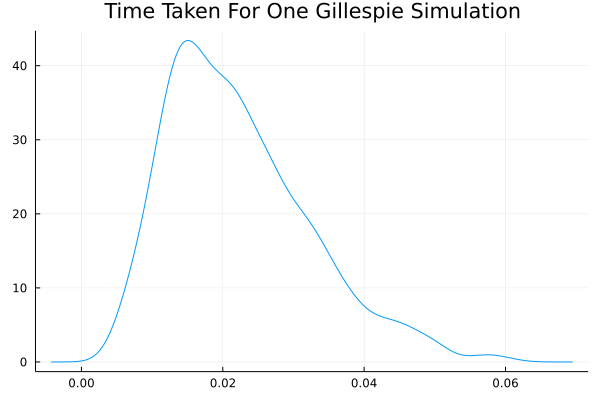

In [32]:
plot(density_points[:,1], density_points[:,2], legend=false, title="Time Taken For One Gillespie Simulation" )